In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm.auto import tqdm
import torchvision.models
import cv2
import matplotlib.style as mplstyle
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

c:\Users\HP\Desktop\phone-detector\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# hyperparams

batch_size = 32 
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 8
lr = 1.9939377918517657e-05
clr = 0.00031384783419999377
dropout = 0.3
weight_decay = 3.2730287919730626e-05
features_to_change = -4
features = -7

In [3]:
imagenet_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    imagenet_normalize
])


test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    imagenet_normalize
])


In [4]:
train_dataset = datasets.ImageFolder(root=r"C:\Users\HP\Desktop\phone-detector\Train-6", transform=train_transforms)
test_dataset  = datasets.ImageFolder(root=r"C:\Users\HP\Desktop\phone-detector\Test-2",  transform=test_transforms)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [6]:
print(train_dataset.class_to_idx)  
print(test_dataset.class_to_idx)

{'Non-Phone-samples': 0, 'Phone-samples': 1}
{'Non-Phone-samples': 0, 'Phone-samples': 1}


In [7]:
model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)

for param in model.features[features:].parameters():
    param.requires_grad = True

print(model.features[features:])

model.classifier = nn.Sequential(
    nn.Linear(25088, 512),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(512, 1)  
)

model.to(device)

Sequential(
  (24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (25): ReLU(inplace=True)
  (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (27): ReLU(inplace=True)
  (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (29): ReLU(inplace=True)
  (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
optimizer = torch.optim.AdamW([
    {"params": model.features[features_to_change:].parameters(), "lr": lr},  
    {"params": model.classifier.parameters(), "lr": clr},     
], weight_decay=weight_decay)


loss_fn = torch.nn.BCEWithLogitsLoss()


In [9]:
train_losses = []
test_losses = []

train_accs = []
test_accs = []

def train_loop(epochs, loader, model, loss_fn, optimizer):
    total_batches = len(loader)

    for epoch in tqdm(range(epochs)):

        total_epoch_loss = 0
        total_acc = 0
        print(f"\n -------- Epoch {epoch} --------")\
        
        for batch, (X, Y) in enumerate(loader):
            model.train()

            X, Y = X.to(device), Y.to(device)

            Y_pred = model(X)
            Y = Y.unsqueeze(1).float()
            loss = loss_fn(Y_pred, Y)
            correct = (Y_pred == Y).sum().item()
            total_acc += correct


            total_epoch_loss += loss.item()
            

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_acc = total_acc / len(loader.dataset)

        total_epoch_loss /= total_batches
        print()
        print(f"Avg training loss: {total_epoch_loss:.2f} | Average accuracy {total_acc:.2f}")
        train_losses.append(total_epoch_loss)
        train_accs.append(total_acc)


def test_loop(loader, model, loss_fn):
    
    total_batches = len(loader)

    model.eval()
    total_loss, total_acc = 0, 0
    all_preds = []
    all_labels = []
    with torch.inference_mode():

        for X, Y in loader:
            
            X, Y = X.to(device), Y.to(device)

            Y_pred = model(X)
            Y = Y.unsqueeze(1).float()
            loss = loss_fn(Y_pred, Y)

            total_loss += loss.item()
            

            probs = torch.sigmoid(Y_pred)
            preds = (probs > 0.5).float()
            correct = (preds == Y).sum().item()
            total_acc += correct

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(Y.cpu().numpy().flatten())

        total_loss /= total_batches
        total_acc = total_acc / len(loader.dataset)

    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"Test loss: {total_loss:.2f} | Test accuracy: {total_acc:.2f}")
    print(f"Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")
    print(f"\nConfusion Matrix:\n{cm}")
    
    test_losses.append(total_loss)
    test_accs.append(total_acc)
    
   
    return {
        'loss': total_loss,
        'accuracy': total_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'preds': all_preds,
        'labels': all_labels
    }
        


In [10]:
train_loop(epochs, train_loader, model, loss_fn, optimizer)

  0%|          | 0/8 [00:00<?, ?it/s]


 -------- Epoch 0 --------


 12%|█▎        | 1/8 [03:26<24:05, 206.44s/it]


Avg training loss: 0.41 | Average accuracy 0.00

 -------- Epoch 1 --------


 25%|██▌       | 2/8 [06:51<20:33, 205.64s/it]


Avg training loss: 0.21 | Average accuracy 0.00

 -------- Epoch 2 --------


 38%|███▊      | 3/8 [10:22<17:19, 207.98s/it]


Avg training loss: 0.15 | Average accuracy 0.00

 -------- Epoch 3 --------


 50%|█████     | 4/8 [13:44<13:42, 205.74s/it]


Avg training loss: 0.13 | Average accuracy 0.00

 -------- Epoch 4 --------


 62%|██████▎   | 5/8 [17:13<10:21, 207.06s/it]


Avg training loss: 0.11 | Average accuracy 0.00

 -------- Epoch 5 --------


 75%|███████▌  | 6/8 [20:40<06:53, 206.78s/it]


Avg training loss: 0.09 | Average accuracy 0.00

 -------- Epoch 6 --------


 88%|████████▊ | 7/8 [24:05<03:26, 206.23s/it]


Avg training loss: 0.08 | Average accuracy 0.00

 -------- Epoch 7 --------


100%|██████████| 8/8 [27:28<00:00, 206.00s/it]


Avg training loss: 0.07 | Average accuracy 0.00


In [11]:
test_metrics = test_loop(test_loader, model, loss_fn)

Test loss: 1.60 | Test accuracy: 0.65
Precision: 0.90 | Recall: 0.44 | F1: 0.60

Confusion Matrix:
[[99  7]
 [80 64]]


In [12]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


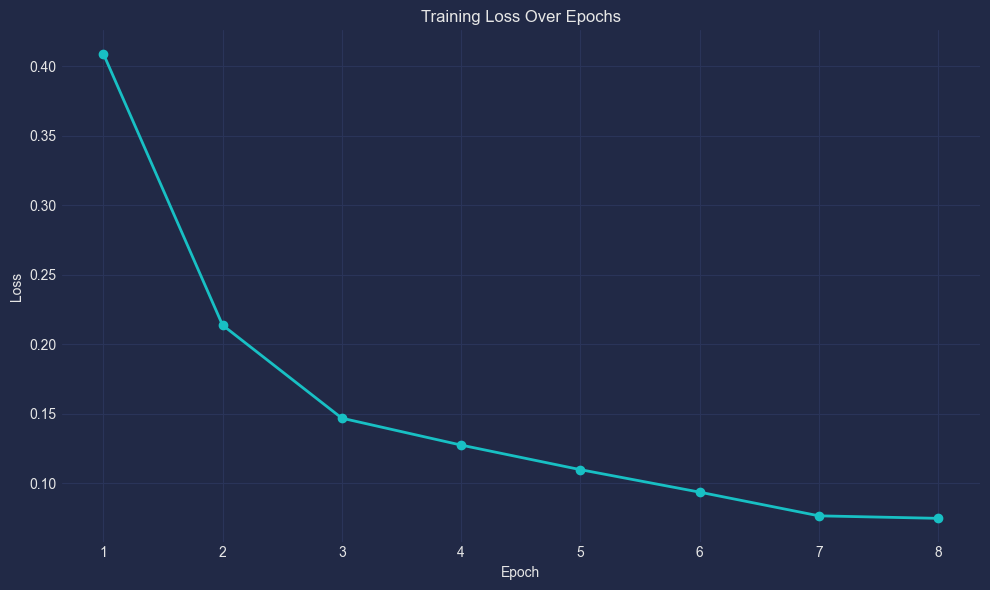

In [13]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.tight_layout()
plt.show()

{'loss': 1.6031556073576212, 'accuracy': 0.652, 'precision': 0.9014084507042254, 'recall': 0.4444444444444444, 'f1': 0.5953488372093023, 'confusion_matrix': array([[99,  7],
       [80, 64]]), 'preds': [np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(1.0), np.float32(0.0), np.float32(0.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0)

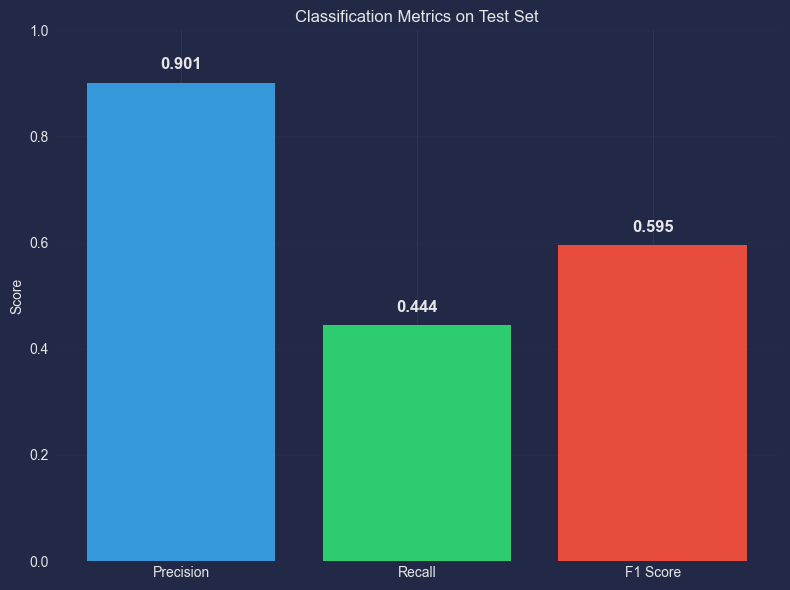

In [16]:

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

metrics_dict = test_metrics
print(metrics_dict)
metric_names = ['Precision', 'Recall', 'F1 Score']
metric_values = [metrics_dict['precision'], metrics_dict['recall'], metrics_dict['f1']]

plt.figure(figsize=(8, 6))
bars = plt.bar(metric_names, metric_values, color=['#3498db', '#2ecc71', '#e74c3c'])
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Classification Metrics on Test Set')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, metric_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{value:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

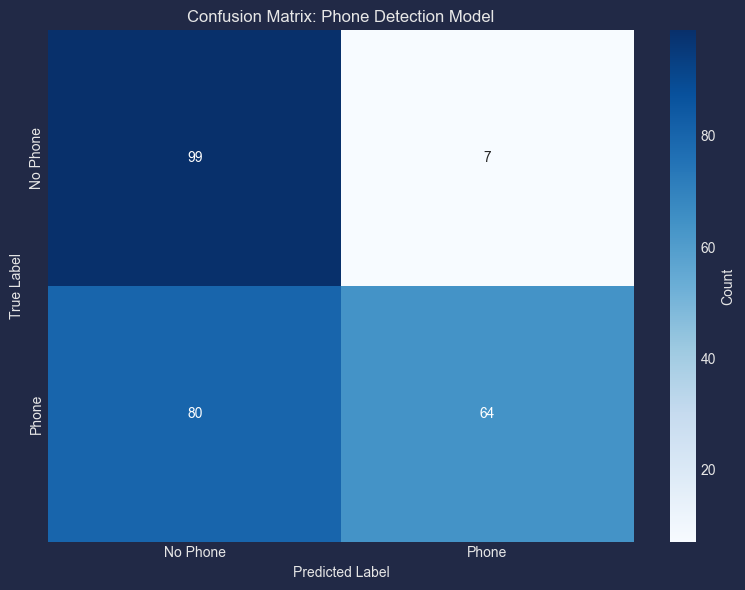

True Negatives: 99
False Positives: 7
False Negatives: 80
True Positives: 64


In [17]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')


cm = metrics_dict['confusion_matrix']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Phone', 'Phone'],
            yticklabels=['No Phone', 'Phone'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Phone Detection Model')
plt.tight_layout()
plt.show()


tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

In [18]:
def live_pred(model):
    cam = cv2.VideoCapture(0)

    while True:

        ret, frame = cam.read()
        if not ret:
            return

        frame = cv2.resize(frame, (224, 224))

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        tensor = torch.from_numpy(rgb_frame).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        tensor = tensor.to(device)

        mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
        std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)
        tensor = (tensor - mean) / std

        with torch.no_grad():
            pred = model(tensor)

            probs = torch.sigmoid(pred)
            prob = probs.item()


        print(f"Prediciton: {1 if prob >= 0.9 else 0} | Actual item: {prob}")
        if cv2.waitKey(1) & 0XFF == ord('q'):
            break

        cv2.imshow("Live feed", frame)

    cam.release()
    cv2.destroyAllWindows()
    return 

In [19]:
live_pred(model)

Prediciton: 0 | Actual item: 0.41974779963493347
Prediciton: 1 | Actual item: 0.9776474237442017
Prediciton: 1 | Actual item: 0.9979350566864014
Prediciton: 1 | Actual item: 0.9982001781463623
Prediciton: 1 | Actual item: 0.9982001781463623
Prediciton: 1 | Actual item: 0.9985864162445068
Prediciton: 1 | Actual item: 0.9985864162445068
Prediciton: 1 | Actual item: 0.9945645332336426
Prediciton: 1 | Actual item: 0.9955211877822876
Prediciton: 1 | Actual item: 0.9955211877822876
Prediciton: 1 | Actual item: 0.9987437129020691
Prediciton: 1 | Actual item: 0.9987437129020691
Prediciton: 1 | Actual item: 0.9980483055114746
Prediciton: 1 | Actual item: 0.9980483055114746
Prediciton: 1 | Actual item: 0.9972088932991028
Prediciton: 1 | Actual item: 0.9972088932991028
Prediciton: 1 | Actual item: 0.9972088932991028
Prediciton: 1 | Actual item: 0.9975684285163879
Prediciton: 1 | Actual item: 0.9975684285163879
Prediciton: 1 | Actual item: 0.9982818365097046
Prediciton: 1 | Actual item: 0.99819821